In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from cleaning_and_preprocessing_function import clean_n_preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import PyTorch components
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print(f"PyTorch Version: {torch.__version__}")


PyTorch Version: 2.7.1+cpu


In [2]:
df = pd.read_csv("./../dataset/port_operations_log.csv")
X = df.drop(columns=['Actual_Operation_Duration_Hours'])
y = df['Actual_Operation_Duration_Hours']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = clean_n_preprocess(X_train)
X_test = clean_n_preprocess(X_test)

## Data Prep, define Neural Network Model, Loss Function, & Optimizer

In [4]:
# --- 1. Data Preparation for PyTorch ---
# Ensure data is in NumPy format, then convert to PyTorch Tensors
X_train_np = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else np.array(X_train)
X_test_np = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else np.array(X_test)
y_train_np = y_train.to_numpy().reshape(-1, 1) if isinstance(y_train, pd.Series) else np.array(y_train).reshape(-1,1) # Ensure 2D for PyTorch
y_test_np = y_test.to_numpy().reshape(-1, 1) if isinstance(y_test, pd.Series) else np.array(y_test).reshape(-1,1)   # Ensure 2D for PyTorch

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # No shuffle for test

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")

input_features = X_train_tensor.shape[1]

# --- 2. Define the Neural Network Model in PyTorch ---
class RegressionNN(nn.Module):
    def __init__(self, input_features, dropout_rate=0.2, l2_reg_strength=0.0): # l2_reg handled by optimizer
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(128) # Batch Normalization
        self.dropout1 = nn.Dropout(dropout_rate) # Dropout

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(64, 32)
        # No Batch Norm or Dropout right before output usually

        self.fc_out = nn.Linear(32, 1) # Output layer for regression

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = self.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.relu(self.fc3(x))
        x = self.fc_out(x)
        return x

# Instantiate the model
# L2 regularization (weight_decay) is typically set in the optimizer in PyTorch
dropout_param = 0.3
pytorch_nn_model = RegressionNN(input_features, dropout_rate=dropout_param)
print("\nPyTorch Model Architecture:")
print(pytorch_nn_model)

# --- 3. Define Loss Function and Optimizer (and L2 Regularization) ---
criterion = nn.MSELoss() # Mean Squared Error Loss
learning_rate = 0.001
l2_reg_param = 0.005 # L2 regularization strength (weight decay)
optimizer = optim.Adam(pytorch_nn_model.parameters(), lr=learning_rate, weight_decay=l2_reg_param)

# Learning Rate Scheduler (similar to ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min',     # Monitor a quantity that should be minimized
                                                 factor=0.2,     # Factor by which lr will be reduced
                                                 patience=10,    # Number of epochs with no improvement
                                                # verbose=True,
                                                 min_lr=0.00001)


X_train_tensor shape: torch.Size([4000, 23])
y_train_tensor shape: torch.Size([4000, 1])

PyTorch Model Architecture:
RegressionNN(
  (fc1): Linear(in_features=23, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc_out): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)


## Model Training

In [5]:
# --- 4. Training Loop with Early Stopping Logic ---
epochs = 200
patience_early_stopping = 20 # For Early Stopping
best_val_mae = float('inf')
epochs_no_improve = 0
best_model_state = None

history_pytorch = {'train_loss_mse': [], 'train_mae': [], 'val_loss_mse': [], 'val_mae': []}

print("\n--- Training PyTorch Neural Network ---")
start_time_pytorch_nn = time.time()

for epoch in range(epochs):
    pytorch_nn_model.train() # Set model to training mode (enables Dropout, BN updates)
    running_train_loss = 0.0
    running_train_mae = 0.0
    train_batches = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()    # Zero the parameter gradients
        outputs = pytorch_nn_model(inputs) # Forward pass
        loss = criterion(outputs, targets) # Calculate loss
        loss.backward()          # Backward pass
        optimizer.step()         # Optimize

        running_train_loss += loss.item() * inputs.size(0)
        running_train_mae += torch.abs(outputs - targets).sum().item() # Sum of absolute errors
        train_batches += inputs.size(0)

    epoch_train_loss = running_train_loss / train_batches
    epoch_train_mae = running_train_mae / train_batches
    history_pytorch['train_loss_mse'].append(epoch_train_loss)
    history_pytorch['train_mae'].append(epoch_train_mae)

    # Validation phase
    pytorch_nn_model.eval() # Set model to evaluation mode (disables Dropout, uses running_mean/var for BN)
    running_val_loss = 0.0
    running_val_mae = 0.0
    val_batches = 0
    with torch.no_grad(): # No need to track gradients for validation
        for inputs_val, targets_val in test_loader:
            outputs_val = pytorch_nn_model(inputs_val)
            val_loss = criterion(outputs_val, targets_val)
            running_val_loss += val_loss.item() * inputs_val.size(0)
            running_val_mae += torch.abs(outputs_val - targets_val).sum().item()
            val_batches += inputs_val.size(0)

    epoch_val_loss = running_val_loss / val_batches
    epoch_val_mae = running_val_mae / val_batches
    history_pytorch['val_loss_mse'].append(epoch_val_loss)
    history_pytorch['val_mae'].append(epoch_val_mae)

    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss (MSE): {epoch_train_loss:.4f}, Train MAE: {epoch_train_mae:.4f}, "
          f"Val Loss (MSE): {epoch_val_loss:.4f}, Val MAE: {epoch_val_mae:.4f}")

    # Learning rate scheduler step (based on validation MAE)
    scheduler.step(epoch_val_mae)

    # Early stopping check
    if epoch_val_mae < best_val_mae:
        best_val_mae = epoch_val_mae
        epochs_no_improve = 0
        best_model_state = pytorch_nn_model.state_dict() # Save the best model state
        # torch.save(pytorch_nn_model.state_dict(), 'best_pytorch_model.pth') # Optionally save to disk
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience_early_stopping:
        print(f"\nEarly stopping triggered after {epoch+1} epochs. Best Val MAE: {best_val_mae:.4f}")
        if best_model_state:
            pytorch_nn_model.load_state_dict(best_model_state) # Restore best model weights
        break

end_time_pytorch_nn = time.time()
training_time_pytorch_nn = end_time_pytorch_nn - start_time_pytorch_nn
print(f"PyTorch Neural Network training time: {training_time_pytorch_nn:.2f} seconds")


--- Training PyTorch Neural Network ---
Epoch [1/200], Train Loss (MSE): 12529.7222, Train MAE: 92.3192, Val Loss (MSE): 8114.3853, Val MAE: 76.7619
Epoch [2/200], Train Loss (MSE): 3432.2020, Train MAE: 46.0528, Val Loss (MSE): 1199.2247, Val MAE: 26.5207
Epoch [3/200], Train Loss (MSE): 1230.6682, Train MAE: 27.4503, Val Loss (MSE): 625.1532, Val MAE: 19.0649
Epoch [4/200], Train Loss (MSE): 731.4833, Train MAE: 20.3824, Val Loss (MSE): 309.0632, Val MAE: 12.3984
Epoch [5/200], Train Loss (MSE): 714.9222, Train MAE: 18.6132, Val Loss (MSE): 264.6631, Val MAE: 11.5097
Epoch [6/200], Train Loss (MSE): 684.1887, Train MAE: 18.5089, Val Loss (MSE): 264.1494, Val MAE: 11.0437
Epoch [7/200], Train Loss (MSE): 590.2588, Train MAE: 17.3442, Val Loss (MSE): 268.2895, Val MAE: 11.5012
Epoch [8/200], Train Loss (MSE): 612.8488, Train MAE: 17.4898, Val Loss (MSE): 209.1302, Val MAE: 10.1739
Epoch [9/200], Train Loss (MSE): 652.9038, Train MAE: 17.8116, Val Loss (MSE): 217.6131, Val MAE: 10.4161

## Model Evaluation & Visualize Training Process

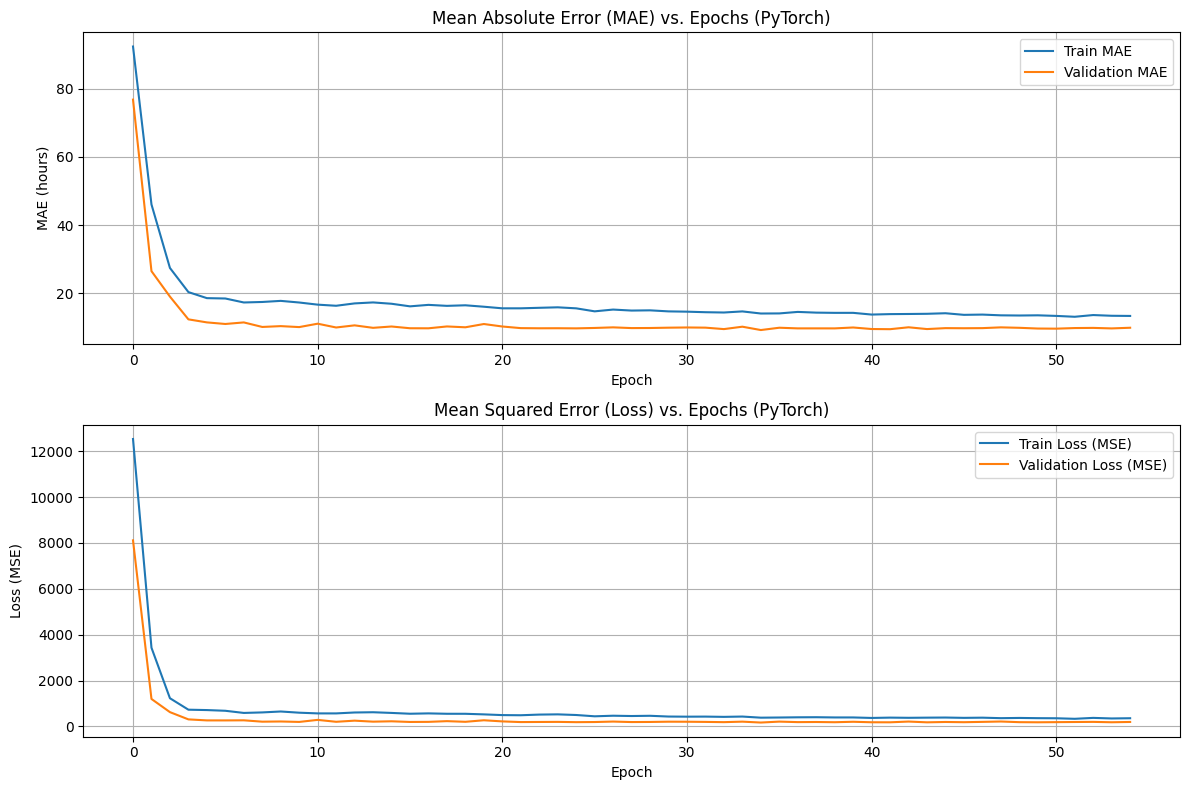


--- PyTorch Neural Network Evaluation on Test Set (with best weights) ---
Test MAE: 9.9414 hours
Test RMSE: 14.0206 hours
Test R-squared: 0.9565


In [ ]:
# --- 5. Evaluate the Model and Visualize Training History ---
history_pytorch_df = pd.DataFrame(history_pytorch)

plt.figure(figsize=(12, 8))
# Plot MAE
plt.subplot(2, 1, 1)
plt.plot(history_pytorch_df.index, history_pytorch_df['train_mae'], label='Train MAE')
plt.plot(history_pytorch_df.index, history_pytorch_df['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) vs. Epochs (PyTorch)')
plt.ylabel('MAE (hours)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot Loss (MSE)
plt.subplot(2, 1, 2)
plt.plot(history_pytorch_df.index, history_pytorch_df['train_loss_mse'], label='Train Loss (MSE)')
plt.plot(history_pytorch_df.index, history_pytorch_df['val_loss_mse'], label='Validation Loss (MSE)')
plt.title('Mean Squared Error (Loss) vs. Epochs (PyTorch)')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on the test set (with best weights if early stopping occurred)
pytorch_nn_model.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = pytorch_nn_model(inputs)
        y_pred_list.append(outputs.numpy())
        y_true_list.append(targets.numpy())

y_pred_pytorch = np.concatenate(y_pred_list).flatten()
y_true_pytorch = np.concatenate(y_true_list).flatten()

test_mae_pytorch = mean_absolute_error(y_true_pytorch, y_pred_pytorch)
test_mse_pytorch = mean_squared_error(y_true_pytorch, y_pred_pytorch)
test_rmse_pytorch = np.sqrt(test_mse_pytorch)
r2_pytorch = r2_score(y_true_pytorch, y_pred_pytorch)

print("\n--- PyTorch Neural Network Evaluation on Test Set (with best weights) ---")
print(f"Test MAE: {test_mae_pytorch:.4f} hours")
print(f"Test RMSE: {test_rmse_pytorch:.4f} hours")
print(f"Test R-squared: {r2_pytorch:.4f}")

# Add PyTorch NN results to the evaluation DataFrame (overview for all models)
if 'evaluation_df' in globals():
    pytorch_nn_results = pd.DataFrame([{
        'Model': 'PyTorch NN',
        'MAE': test_mae_pytorch,
        'RMSE': test_rmse_pytorch,
        'R2': r2_pytorch,
        'Training Time (s)': training_time_pytorch_nn
    }])
    evaluation_df = pd.concat([evaluation_df, pytorch_nn_results], ignore_index=True)
    print("\n--- Updated Evaluation Summary Table ---")
    print(evaluation_df.sort_values(by='MAE'))

## Visualize Predictions

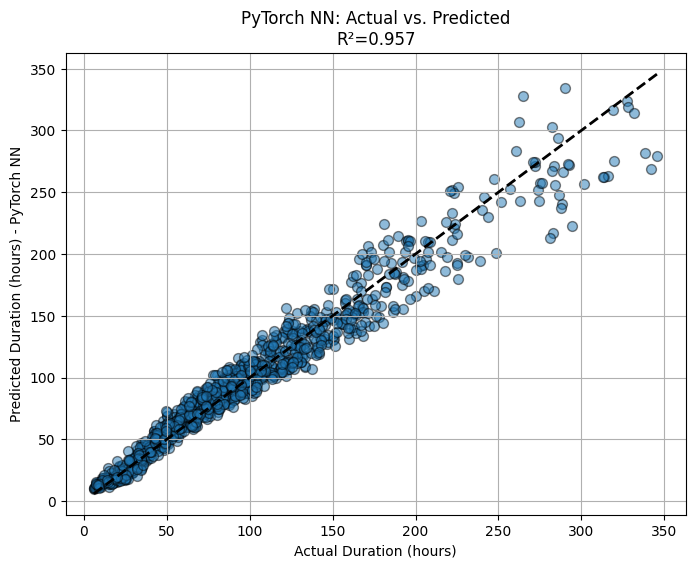

In [7]:
# --- 6. Visualize Predictions ---
plt.figure(figsize=(8, 6))
plt.scatter(y_true_pytorch, y_pred_pytorch, alpha=0.5, edgecolors='k', s=50)
plt.plot([y_true_pytorch.min(), y_true_pytorch.max()], [y_true_pytorch.min(), y_true_pytorch.max()], 'k--', lw=2)
plt.xlabel('Actual Duration (hours)')
plt.ylabel('Predicted Duration (hours) - PyTorch NN')
plt.title(f'PyTorch NN: Actual vs. Predicted\nR²={r2_pytorch:.3f}')
plt.grid(True)
plt.show()